In [15]:
%cd /content/drive/MyDrive/Colab\ Notebooks/입찰/LSTM

/content/drive/MyDrive/Colab Notebooks/입찰/LSTM


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.optimizers import Adam, RMSprop

In [17]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test

sc1 = MinMaxScaler(feature_range=(0,1))
scaled_train = sc1.fit_transform(train_raw) # scaled train
scaled_test = sc1.fit_transform(test_raw) # scaled test

In [18]:
def datamake(data):
  ndata = []
  c = 2
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    mean = sum / 2
    for j in range(c):
      if j==0:
        mean2 = (mean+data[i]) / 2
      elif j==1:
        mean2 = (mean+data[i+1]) / 2
      ndata.append(mean2)
  ndata.append(data[-1])
  ndata = np.array(ndata)
  return ndata

In [19]:
train_added_scaled = datamake(scaled_train)
test_added_scaled = datamake(scaled_test)

In [20]:
print(train_added_scaled.shape)
print(test_added_scaled.shape)

(7327, 1)
(814, 1)


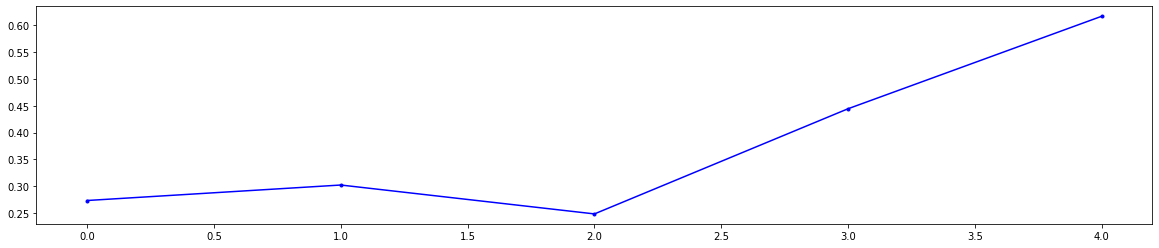

In [21]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(scaled_train[-5:,:], '.-',color = 'blue', label = 'GroundTruth')

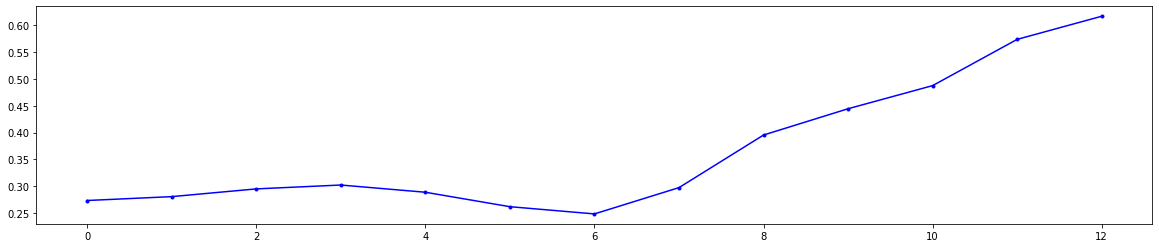

In [22]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(train_added_scaled[-13:,:], '.-',color = 'blue', label = 'GroundTruth')

In [23]:
seq_length = 50 ############## 6, 7

In [24]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [25]:
X_train, Y_train = make_data(train_added_scaled) # train_added_scaled
X_test, Y_test = make_data(test_added_scaled) # test_added_scaled

In [26]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

concat = concatenate([x, y])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
output = Dense(1)(output)
model = Model(inputs = inputs, outputs = output)

#model.summary()

In [27]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, Y_train, epochs = 50, batch_size = 10, validation_split=0.1)

Epoch 1/50
655/655 [==============================] - 17s 18ms/step - loss: 0.0266 - val_loss: 0.0198
Epoch 2/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0157 - val_loss: 0.0053
Epoch 3/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 4/50
655/655 [==============================] - 11s 16ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 5/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 6/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/50
655/655 [==============================] - 11s 16ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 9/50
655/655 [==============================] - 10s 16ms/step - loss: 0.0026 - val_loss: 9.7980e-04
Epoch 10/50
655/655 [==============================] - 10s 16ms/step - loss: 0

In [28]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)
train = sc1.inverse_transform(train_added_scaled)
mean_train_error = np.average(np.abs(train[seq_length:,:] - predicted_X_train))

print("평균 training error:", mean_train_error)

평균 training error: 0.04455515496424429


In [29]:
predicted_X_test = model.predict(X_test)
predicted_X_test = sc1.inverse_transform(predicted_X_test)
test = sc1.inverse_transform(test_added_scaled)
mean_test_error = np.average(np.abs(test[seq_length:,:] - predicted_X_test))

print("평균 test error:", mean_test_error)

평균 test error: 0.04950525834240466


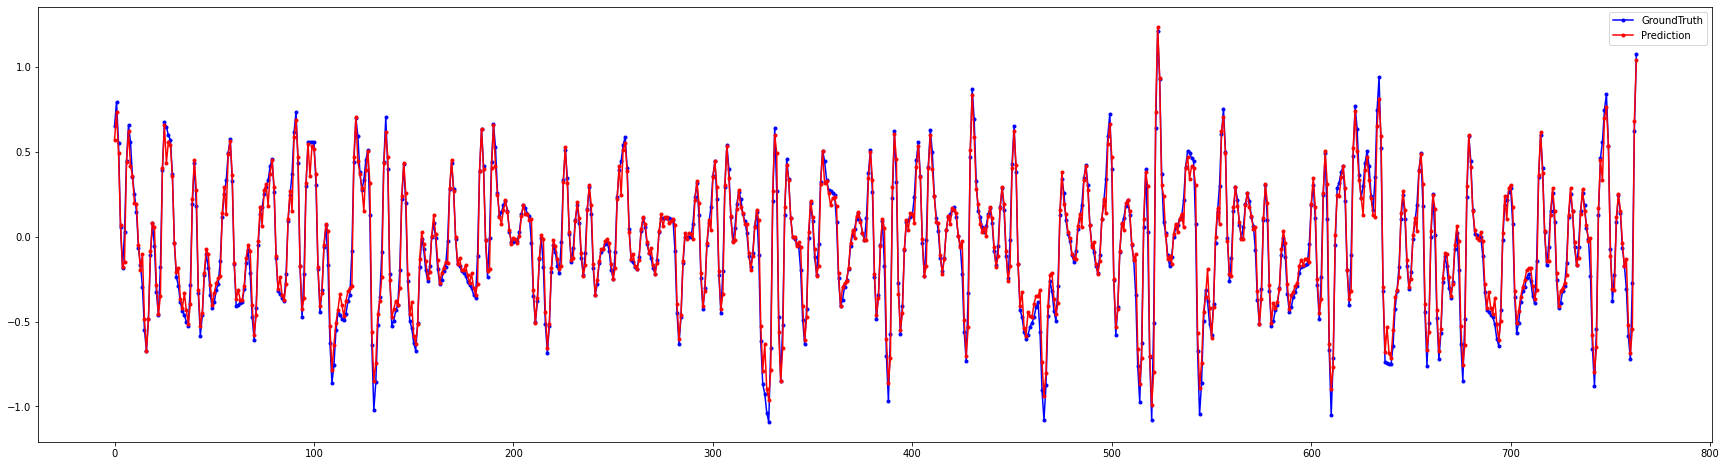

In [30]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test[seq_length:,:], '.-',color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_test, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM2_test')

In [31]:
pred1 = model.predict(test_added_scaled[-seq_length:].reshape(1,seq_length,1)) # temp_pred 1
dummy = test_added_scaled[-seq_length:] 
dummy = np.append(dummy, pred1, axis=0) 

pred2 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred 2
dummy = np.append(dummy, pred2, axis=0) 

pred3 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############# first
dummy = np.append(dummy, pred3, axis=0)

pred4 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred1
dummy = np.append(dummy, pred4, axis=0) 

pred5 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred2
dummy = np.append(dummy, pred5, axis=0)

pred6 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## second
dummy = np.append(dummy, pred6, axis=0)

pred7 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred1
dummy = np.append(dummy, pred7, axis=0) 

pred8 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred2
dummy = np.append(dummy, pred8, axis=0)

pred9 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## third

result1 = sc1.inverse_transform(pred3)
result2 = sc1.inverse_transform(pred6)
result3 = sc1.inverse_transform(pred9)
print('Predict1 : ', result1)
print('Predict2 : ', result2)
print('Predict3 : ', result3)

Predict1 :  [[-0.2800913]]
Predict2 :  [[-0.17320281]]
Predict3 :  [[0.08181316]]


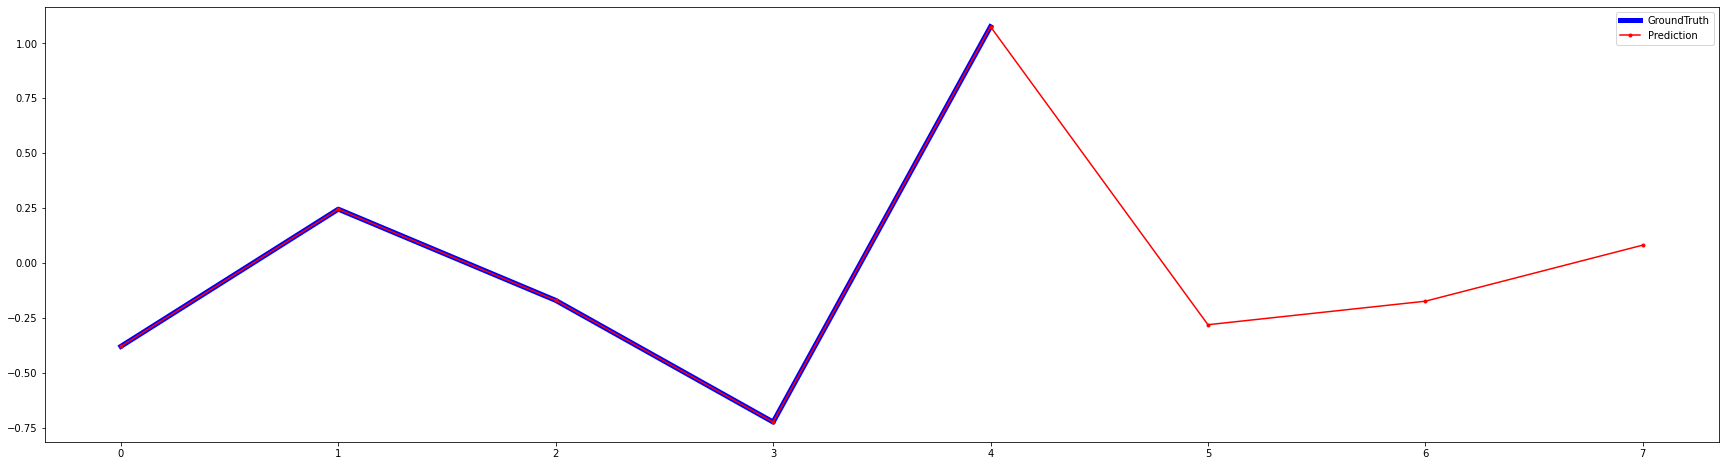

In [32]:
dum = test_raw[-5:]
dum = np.append(dum, result1)
dum = np.append(dum, result2)
dum = np.append(dum, result3)
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test_raw[-5:], '.-',color = 'blue', label = 'GroundTruth', linewidth=5.0)
plt.plot(dum, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM2_predict')